# Práctica examen año pasado: ETL

#### Autor: Blanco García, Gabriel
#### Colegio Universitario de Estudios Financieros 
#### Madrid, diciembre de 2020

La práctica consiste en trabajar con dos conjuntos de datos de indicadores económicos de deuda y desarrollo de diferentes países, y realizar distintos cálculos.

In [1]:
# Operaciones basicas 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Expresiones regulares
import re

# Spark para trabajar en rdd
import pyspark
from pyspark import SparkContext

# Operaciones para el último ejercicio
from pyspark.sql import SparkSession
from pyspark.sql import *
from collections import OrderedDict
from scipy import stats

sns.set()

# 0. Leemos los metadatos

Primero, se leen los ficheros con metadatos, con el fin de comprender cada variable. Se puede obtener más información consultando la página web del [Banco Central](https://data.worldbank.org/indicator)

##### Fichero expliación var 1920

- SP.DYN.CBRT.IN: es la tasa de natalidad por cada 1000 habitantes

- SH.DTH.INJR.ZS: porcentaje de muertes cuya causa es una lesión, sobre el total de muertes.

- GC.DOD.TOTL.CN: deuda total del gobierno central (LCU = local currency, moneda local)

- GC.DOD.TOTL.GD.ZS: deuda del gobierno central en porcentaje sobre el PIB 

- SH.ALC.PCAP.LI: consumo per cápita de alcohol, en litros, estimaciones para ciudadanos de más de 15 años. Son litros de alchohol puro, no de bebidas con alcohol.

- SH.ALC.PCAP.FE.LI: mismo indicador, pero para mujeres

- SH.ALC.PCAP.MA.LI: mismo indicador, pero para hombres

##### Fichero expliación var deuda 1920

- contry_name: nombre del país
- country_code: código del país  


- DT.DIS.DLXF.CD: desembolsos en deuda externa a largo plazoDisbursements on external debt, long-term (DIS, current USD)
- DT.INT.DLXF.CD: pago de intereses de deuda externa a largo plazoInterest payments on external debt, long-term (INT, current USD)  


- DT.AMT.BLAT.CD: deuda bilateral, cuantia 
- DT.DIS.BLAT.CD: deuda bilateal, desembolsos
- DT.INT.BLAT.CD: deuda bilateral, intereses   


- DT.AMT.MLAT.CD: deuda multilateral, cuantia
- DT.DIS.MLAT.CD: deuda multilateral, desembolsos 
- DT.INT.MLAT.CD: deuda multilateral, intereses  
  
  
- DT.AMT.OFFT.CD: creditos oficiales, cuantia 
- DT.DIS.OFFT.CD: creditos oficiales, desembolsos 
- DT.INT.OFFT.CD: creditos oficiales, intereses 
  
  
- DT.AMT.DLXF.CD: repagos de principal en deuda externa a largo plazo, cuantía
  
  
- DT.INT.DPNG.CD: pagos de interses en deuda externa, privada no garantizada 


- DT.AMT.PBND.CD: bonos, cuantia 
- DT.INT.PBND.CD: bonos, intereses 
  

- DT.AMT.PCBK.CD: deuda bancos comerciales, cuantia 
- DT.DIS.PCBK.CD: deuda bancos comerciales, desembolsos
- DT.INT.PCBK.CD: deuda bancos comerciales, interseses


- DT.AMT.PROP.CD: otros creditos privados, cuantia  
- DT.DIS.PROP.CD: otros creditos privados, desembolsos
- DT.INT.PROP.CD: otros creditos privados, intereses


- DT.AMT.PRVT.CD: acredores privados, cuantia 
- DT.DIS.PRVT.CD: acredores privados, desembolsos 
- DT.INT.PRVT.CD: acredores privados, intereses


- DT.AMT.DPNG.CD: repagos de principal en extterna no gartantizada, cuantia.

## 1. Creamos el contexto Spark

Como se está trabajando desde Docker no hace falta instalar nada. Se crea el contexto Spark de la siguiente manera

In [2]:
sc = SparkContext()

In [3]:
conf = sc.getConf()

In [4]:
conf.getAll()

[('spark.driver.host', '172.17.0.2'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '44081'),
 ('spark.app.id', 'local-1610618679349'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'pyspark-shell')]

## 1 Creamos el rdd con los datos

Leemos los dos rdd para ver que aspecto tienen

In [5]:
rdd_desarrollo = sc.textFile('../work/data/indicadores_desarrollo.csv')
rdd_deuda = sc.textFile('../work/data/indicadores_deuda.csv')

In [6]:
rdd_desarrollo.take(3)

['country_name,country_code,anho,GC.DOD.TOTL.CN,GC.DOD.TOTL.GD.ZS,SP.DYN.CBRT.IN',
 'Albania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259',
 'Albania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197']

In [7]:
rdd_deuda.take(3)

['country_name,country_code,DT.AMT.BLAT.CD,DT.AMT.DLXF.CD,DT.AMT.DPNG.CD,DT.AMT.MLAT.CD,DT.AMT.OFFT.CD,DT.AMT.PBND.CD,DT.AMT.PCBK.CD,DT.AMT.PROP.CD,DT.AMT.PRVT.CD,DT.DIS.BLAT.CD,DT.DIS.DLXF.CD,DT.DIS.MLAT.CD,DT.DIS.OFFT.CD,DT.DIS.PCBK.CD,DT.DIS.PROP.CD,DT.DIS.PRVT.CD,DT.INT.BLAT.CD,DT.INT.DLXF.CD,DT.INT.DPNG.CD,DT.INT.MLAT.CD,DT.INT.OFFT.CD,DT.INT.PBND.CD,DT.INT.PCBK.CD,DT.INT.PROP.CD,DT.INT.PRVT.CD',
 'Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
 'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2']

Antes de nada, se crean diccionarios, con el nombre de cada variable como key, y el número de la columna como value, para no tener que estar buscando en los datos la posición de cada columna.

In [8]:
# Extraccion de los header
header_desarrolo = rdd_desarrollo.take(1)
header_deuda = rdd_deuda.take(1)

In [9]:
# Creacion de listas de strings separadas por coma
header_desarrollo_split = ' '.join(header_desarrolo).split(',')
header_deuda_split = ' '.join(header_deuda).split(',')

In [10]:
# Generación de los diccionarios
# Para desarollo
keys_desarrollo = header_desarrollo_split 
values_desarrolo = range(len(header_desarrollo_split))

for i in values_desarrolo:
    diccionario_desarrolo = dict(zip(keys_desarrollo, values_desarrolo))

# Para deuda 
keys_deuda = header_deuda_split
values_deuda = range(len(header_deuda_split))

for i in values_deuda:
    diccionario_deuda = dict(zip(keys_deuda, values_deuda))

Como los diccionarios están desordenados, los ordeno, aunque no sería necesario

In [11]:
diccionario_desarrolo = OrderedDict(sorted(diccionario_desarrolo.items(), key = lambda x: x[1]))
diccionario_deuda = OrderedDict(sorted(diccionario_deuda.items(), key = lambda x: x[1]))

De este modo, si en un ejercicio aparece una variable, se puede acceder rápido al número de su columna, y no hay que estar buscando constantemente su número de columna en los datos raw con header

In [12]:
# Si necesito la variable DT.DIS.DLXF.CD, accedo
diccionario_deuda['DT.DIS.DLXF.CD']
# y así conozco el índice en el que está para usarlo en el lambda del rdd

12

# Parseado

Parsear los datos significa transformarlos de tal manera que su formato sea el adecuado para trabajar con ellos. Es necesario parsear ambos archivos

### Indicadores de desarrollo

Problema con desarrolo: hay países, como Bahamas, cuyo nombre está escrito como nombre compuesto, separado por comas "Bahamas, The", y si se hace split por comas, se generarían dos columnas, una con Bahamas y otra con The. Para arreglarlo, se utilizan expresiones regulares.

Se define una función, que utiliza `re.sub()` para buscar el patrón deseado y eliminarlo. El patrón se compone de comillas, coma, espacio y palabra. También se aprovecha la función para eliminar la parte de los años que está entre brackets, que no sirve para nada. se elimina con `\s[.*?\]`. La función funciona sobre linesa individuales, así que para utilizarla hay que usar map. Al escribir toda la expresión en el mismo re.sub, se recorre la lista una sola vez.

In [13]:
def parseo_comillas_y_brackets(linea):

    linea = re.sub(r'["]|,(\s)\w+|\s\[.*?\]', '', linea) # busca el patrón y lo elimina (sustitye por '')

    return linea   

La función trabaja sobre lineas individuales, así que para aplicarla a todo el rdd, hay que usar `.map()`

In [14]:
rdd_desarrollo_parseado = rdd_desarrollo.map(parseo_comillas_y_brackets) # aplico la funcion

In [15]:
rdd_desarrollo_parseado.take(10) # resultado

['country_name,country_code,anho,GC.DOD.TOTL.CN,GC.DOD.TOTL.GD.ZS,SP.DYN.CBRT.IN',
 'Albania,ALB,2014,1023040800000,73.3202469198429,12.259',
 'Albania,ALB,2015,1145500940000,79.8644448747259,12.197',
 'Albania,ALB,2016,1188814490000,80.7355748396923,12.08',
 'Australia,AUS,2014,674700000,0.042207528166503,13.2',
 'Australia,AUS,2015,762718000,0.0469480198522591,12.9',
 'Australia,AUS,2016,907555000,0.054648482520169,12.9',
 'Bahamas,BHS,2014,5158420000,47.2672793747079,14.34',
 'Bahamas,BHS,2015,5655150000,48.1195170307089,14.224',
 'Bahamas,BHS,2016,6138814000,51.4207431481606,14.131']

Problema solucionado. Ya se puede hacer split por comas.

In [18]:
rdd_desarrollo_parseado_split = rdd_desarrollo_parseado.map(lambda x: x.split(','))

In [19]:
rdd_desarrollo_parseado_split.take(10)

[['country_name',
  'country_code',
  'anho',
  'GC.DOD.TOTL.CN',
  'GC.DOD.TOTL.GD.ZS',
  'SP.DYN.CBRT.IN'],
 ['Albania', 'ALB', '2014', '1023040800000', '73.3202469198429', '12.259'],
 ['Albania', 'ALB', '2015', '1145500940000', '79.8644448747259', '12.197'],
 ['Albania', 'ALB', '2016', '1188814490000', '80.7355748396923', '12.08'],
 ['Australia', 'AUS', '2014', '674700000', '0.042207528166503', '13.2'],
 ['Australia', 'AUS', '2015', '762718000', '0.0469480198522591', '12.9'],
 ['Australia', 'AUS', '2016', '907555000', '0.054648482520169', '12.9'],
 ['Bahamas', 'BHS', '2014', '5158420000', '47.2672793747079', '14.34'],
 ['Bahamas', 'BHS', '2015', '5655150000', '48.1195170307089', '14.224'],
 ['Bahamas', 'BHS', '2016', '6138814000', '51.4207431481606', '14.131']]

Elimino el header

In [20]:
desarrollo_sin_header = rdd_desarrollo_parseado_split.filter(lambda x: 'country_name' not in x)

Se define una función que permita especificar cuando se quiere utilizar el formato entero y cuando el decimal

In [115]:
def parseo_numeros(numero, formato='decimal'):
    if (formato == 'decimal'):
        return float(numero)
    else:
        return int(numero)

In [116]:
#desarrollo_sin_header = desarrollo_sin_header.map(lambda x: [x[0], 
#                                                              x[1], 
#                                                              parseo_numeros(x[2], 'entero'),
#                                                              parseo_numeros(x[3], 'entereo'),
#                                                              parseo_numeros(x[4]),
#                                                              parseo_numeros(x[5])])

Por algun motivo, si aplico esa función, luego distinct no funciona con el primer elemnto, así que la dejo sin ejecutar. Pero lo más comodo sería poder parsear todos los números a float/int al principio, y así no tener que preocuparse de ello en cada ejercicio, minimizando los errores.

In [21]:
desarrollo_sin_header.take(3) # Los datos sin header

[['Albania', 'ALB', '2014', '1023040800000', '73.3202469198429', '12.259'],
 ['Albania', 'ALB', '2015', '1145500940000', '79.8644448747259', '12.197'],
 ['Albania', 'ALB', '2016', '1188814490000', '80.7355748396923', '12.08']]

### Indicadores de deuda

Se inspecciona con un `.take()`

In [24]:
rdd_deuda.take(5)

['country_name,country_code,DT.AMT.BLAT.CD,DT.AMT.DLXF.CD,DT.AMT.DPNG.CD,DT.AMT.MLAT.CD,DT.AMT.OFFT.CD,DT.AMT.PBND.CD,DT.AMT.PCBK.CD,DT.AMT.PROP.CD,DT.AMT.PRVT.CD,DT.DIS.BLAT.CD,DT.DIS.DLXF.CD,DT.DIS.MLAT.CD,DT.DIS.OFFT.CD,DT.DIS.PCBK.CD,DT.DIS.PROP.CD,DT.DIS.PRVT.CD,DT.INT.BLAT.CD,DT.INT.DLXF.CD,DT.INT.DPNG.CD,DT.INT.MLAT.CD,DT.INT.OFFT.CD,DT.INT.PBND.CD,DT.INT.PCBK.CD,DT.INT.PROP.CD,DT.INT.PRVT.CD',
 'Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
 'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2',
 'Algeria,DZA,95188724.6,171185188.1,75420000,0,95188724.6,,576463.5,0,576463.5,10320772.2,10320772.2,,10320772.2,,,,7680627.6,19031728.7,3220000,8094779,

Aquí hay que encargarse de los nulos, y también hay países con una coma en el nombre. Se define otra función de parseo para que los nullos se cambien por 'null' y sean fácilmente localizables.

In [60]:
def parseo_numeros_con_nulos(linea):
    
    linea = re.sub(r',,,,,|,,,,|,,,', ',null,', linea)  # cuando encuentra esos patrones, de comas sin letras dentro, los 
                                                        # cambia por ',null,'.
    linea = re.sub(r',,', 'null', linea)

    return linea

In [61]:
rdd_deuda_parseada_split = rdd_deuda.map(parseo_comillas_y_brackets).\
                                     map(parseo_numeros_con_nulos).\
                                     map(lambda x: x.split(','))

Se elimina el header

In [62]:
deuda_sin_header = rdd_deuda_parseada_split.filter(lambda x: 'country_name' not in x)

In [63]:
deuda_sin_header.take(2)

[['Afghanistan',
  'AFG',
  '61739336.9',
  '100847181.9null39107845',
  '100847181.9',
  'null',
  '49114729.4',
  '72894453.7',
  '23779724.3',
  '72894453.7',
  'null',
  '39903620.1',
  '53239440.1null13335820',
  '53239440.1',
  'null',
  ''],
 ['Albania',
  'ALB',
  '54250280.6',
  '790248675.2',
  '514185620',
  '182197616.7',
  '236447897.3',
  '0',
  '39445139.5',
  '170018.4',
  '39615157.9',
  '76050616.1',
  '317194512.5',
  '234321242.3',
  '310371858.4',
  '4542664.9',
  '2279989.2',
  '6822654.1',
  '13847333.6',
  '165602386.9',
  '87884000',
  '28101536.1',
  '41948869.7',
  '31030688.2',
  '4618504.3',
  '120324.7',
  '35769517.2']]

## 2. Numero de países distintos en cada dataset. Coinciden?

Se resuelve utilizando:
- `.map` y `lambda` para extraer la columna de interés
- `.distinct` para extaer el número de elementos únicos
- `.count` para contarlos

In [124]:
distintos_desarrollo = desarrollo_sin_header.map(lambda x: x[0]).distinct().count()
distntos_dedua = deuda_sin_header.map(lambda x: x[0]).distinct().count()

print('El número de países distintos en el dataset de desarrollo es', distintos_desarrollo)
print('El número de países distintos en el dataset de deuda es', distntos_dedua)

El número de países distintos en el dataset de desarrollo es 51
El número de países distintos en el dataset de deuda es 124


El numero de países en cada dataset no coincide

## 3. Total de deuda contraida por cada país

La columna que interesa es el total de deuda DT.AMT.MLAT.CD, se obtiene su posición con el diccionario

In [64]:
columna_deuda = diccionario_deuda['DT.AMT.MLAT.CD']
columna_deuda

5

Hay que eliminar los nulos con un filter. Elimino de la columna 2 a 18 porque prefiero eliminar todos los nulos de una sola vez, que tener que filtar antes de cada ejercicio

In [146]:
deuda_sin_nulos = deuda_sin_header.filter(lambda x: 'null' not in x[2:18]).cache() # porque se va a volver a usar

In [147]:
deuda_sin_nulos.take(2)

[['Albania',
  'ALB',
  '54250280.6',
  '790248675.2',
  '514185620',
  '182197616.7',
  '236447897.3',
  '0',
  '39445139.5',
  '170018.4',
  '39615157.9',
  '76050616.1',
  '317194512.5',
  '234321242.3',
  '310371858.4',
  '4542664.9',
  '2279989.2',
  '6822654.1',
  '13847333.6',
  '165602386.9',
  '87884000',
  '28101536.1',
  '41948869.7',
  '31030688.2',
  '4618504.3',
  '120324.7',
  '35769517.2'],
 ['Cameroon',
  'CMR',
  '9999925153.3',
  '10404814960.2',
  '102376444.4',
  '152095968.1',
  '10152021121.4',
  '0',
  '128608183.9',
  '21809210.5',
  '150417394.4',
  '17090544247.5',
  '18186662060.4',
  '850036788.1',
  '17940581035.6',
  '196167124.8',
  '49913900',
  '246081024.8',
  '120877158.5',
  '280795576.4',
  '23235000',
  '45124721.8',
  '166001880.3',
  '65222000',
  '20590696.1',
  '5746000',
  '91558696.1']]

Se extraen las columnas de país y deuda.

In [148]:
total_deuda_pais = deuda_sin_nulos.map(lambda x: (x[0], # nombre de cad país
                                                  float(x[columna_deuda]))) # deuda de cada país

In [149]:
total_deuda_pais.take(10) # resultado

[('Albania', 182197616.7),
 ('Cameroon', 152095968.1),
 ('Dominican Republic', 254728306.1),
 ('Ghana', 130202003.1),
 ('IDA only', 4884095623.3),
 ('Indonesia', 2469145824.7),
 ('Lao PDR', 80684114.6),
 ('Least developed countries: UN classification', 4084275524.2),
 ('Philippines', 739056427.3),
 ('Serbia', 715223963.7)]

## 4. Media de los indicadores de deuda DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

Se obtienen las posiciones de las columnas

In [143]:
deuda_total = diccionario_deuda['DT.AMT.BLAT.CD']
deuda_pagos = diccionario_deuda['DT.DIS.BLAT.CD']
deuda_intereses = diccionario_deuda['DT.INT.BLAT.CD']

print(deuda_total)
print(deuda_pagos)
print(deuda_intereses)

2
11
18


Se define una función para calcular la media. La función utiliza `.aggregate` y realiza dos tareas: suma todos los elementos de la lista, y cuenta el número de elementos. Devuelve una tupla con la suma y la cuenta. Así, la media se calcula dividiendo el primer elemento (la suma) entre el segundo (el total) y la lista solo se recorre una vez para sumar y contar al mismo tiempo. Recordemos la expresióm matemática de la media

$$Media\left(X\right)=\frac{\sum_{i=1}^N{X_{i}}}{N}$$

In [151]:
def media(indicador_columna, nombre_indicador, datos):
    
    columna = datos.map(lambda x: float(x[indicador_columna])) # extrae la columna de interes como float
    
    suma_columna = columna.aggregate( # y hace el agregado
    (0,0), # lista vacía como valor inicial
        
    (lambda acc, value: (acc[0] + value, acc[1] + 1)), # a cada valor, le suma el siguiente. acc[1] + 1 para que empieze en 1
                                                       # la cuenta
    (lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))

    )
    
    media = round(suma_columna[0] / suma_columna[1], 3)
    
   
    print('La media del indicador', nombre_indicador, 'es:', media)

In [153]:
# Aplico la función
media(deuda_total, 'total de deuda', deuda_sin_nulos)
media(deuda_pagos, 'pagos de deuda', deuda_sin_nulos)
media(deuda_intereses, 'intereses de deuda', deuda_sin_nulos)

La media del indicador total de deuda es: 2970822362.392
La media del indicador pagos de deuda es: 5410625976.1
La media del indicador intereses de deuda es: 562152096.3


## 5. Los 20 países con DT.AMT.DLXF.CD más alto

Se extrae el código de la columna de repagos de deuda extranjera

In [155]:
repagos_extranjero =  diccionario_deuda['DT.AMT.DLXF.CD']

Se construye un key value, donde la key sea la deuda del país, y el value el nombre, para poder usar `.sortByKey` de manera descendente, y obtener los 20 primeros países

In [157]:
deuda_paises_key_value = deuda_sin_nulos.map(lambda x: (float(x[repagos_extranjero]), # la columna de la deuda hace de key
                                                        
                                                        x[0]) # el nombre del país hace de value
                                            
                                            ).sortByKey(ascending= False).take(20)  # orden descendente, 20 países con más deuda

In [36]:
# Resultado
deuda_paises_key_value

[(96218620835.7, 'China'),
 (90041840304.1, 'Brazil'),
 (66589761833.5, 'Russian Federation'),
 (51555031005.8, 'Turkey'),
 (48756295898.2, 'South Asia'),
 (31923507000.8, 'India'),
 (30916112653.8, 'Indonesia'),
 (27482093686.4, 'Kazakhstan'),
 (25218503927.0, 'Mexico'),
 (25197029299.4, 'Least developed countries: UN classification'),
 (20483289208.0, 'IDA only'),
 (14013783350.4, 'Romania'),
 (11985674438.7, 'Colombia'),
 (10404814960.2, 'Cameroon'),
 (9878659207.2, 'Venezuela'),
 (9692114176.9, 'Egypt Rep.'),
 (9506919669.6, 'Lebanon'),
 (9474257551.9, 'South Africa'),
 (8873505909.2, 'Vietnam'),
 (8336013891.3, 'Pakistan')]

## 6. Países con los datos informados todos los años

Hay que ver cuantos años hay en la tabla. Se utiliza distinct

In [158]:
desarrollo_sin_header.map(lambda x: x[2]).distinct().collect() # Años 2014, 2015, 2016, 2017

['2014', '2015', '2017', '2016']

Los países que aparezcan menos de cuatro veces no tienen datos todos los años. Sec construye un key:value con el nombre del país y la cuenta de las veces que aparecen sus años

In [159]:
paises_year_key_value = desarrollo_sin_header.map(lambda x: ((x[0]), x[2])).countByKey()

Se un nuevo diccionario solo con aquellos países cuyo value, la cuenta de veces que aparece, sea 4. Se emplea la estructura de list comprehension, pero con diccionario. La estructura es `[f(x)for x in list(x1, x2...xn)]`. Funciona igual con diccionarios

In [162]:
paises_completos =  {pais:cuenta_years for (pais, cuenta_years) in paises_year_key_value.items() 
                                                                if cuenta_years  == 4} # solo si satsiface la condición de 
                                                                                       # aparecer 4 veces

In [163]:
paises_completos

{'Malawi': 4}

El único país con datos para los 4 años es Malawi

## 7. Media anual de los distintos indicadores de desarrollo

Se obtienen los códigos de las columnas, y se crea un pequeño diccionario con la estructura `{número de columna: nombre del indicador}`

In [83]:
diccionario_desarrolo # todas las variables

OrderedDict([('country_name', 0),
             ('country_code', 1),
             ('anho', 2),
             ('GC.DOD.TOTL.CN', 3),
             ('GC.DOD.TOTL.GD.ZS', 4),
             ('SP.DYN.CBRT.IN', 5)])

In [178]:
# Diccionario con el nombre de las columnas en función del número, para que quede mejor el print
nombre_indicadores = dict({3: 'Deuda central total', 
                           4: 'Deuda central en porcentaje sobre pib', 
                           5: 'Tasa de natalidad'})

Se define una función para calcular las medias anuales. Es similar a la anterior, pero permite especificar el año para el que se quiere calcular

In [82]:
def media_anual(numero_indicador, año):
    
    columna = desarrollo_sin_header.filter(lambda x: año in x).\
                                       map(lambda x: float(x[numero_indicador])) # filtra por el año que se especifique
                                                                                 # y extrae la variable
        
    suma_columna = columna.aggregate( # el resto la función es como la función de la media definida antes
    (0,0), # lista vacía como valor inicial
    (lambda acc, value: (acc[0] + value, acc[1] + 1)), 
    (lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))
)
    
    media = round(suma_columna[0] / suma_columna[1], 3)
    print('La media para el año', año, 'es:', media)

Creo una lista con los distintos años para iterar, y una lista con los indicadores de las columnas

In [172]:
years = desarrollo_sin_header.map(lambda x: x[2]).distinct().collect()

In [173]:
numeros_indicadores = [3, 4, 5]

Defino un doble foor para calcular la media de cada indicador en cada uno de los años, utilizando la función

In [244]:
for numero in numeros_indicadores:
    print(nombre_indicadores[numero])
    
    for year in years:
        media_anual(numero, year)
          
    print('-------------------------------------------------')

Deuda central total
La media para el año 2014 es: 103442758732953.23
La media para el año 2015 es: 131824403915902.5
La media para el año 2017 es: 2239858619962.69
La media para el año 2016 es: 158813821548065.94
-------------------------------------------------
Deuda central en porcentaje sobre pib
La media para el año 2014 es: 56.844
La media para el año 2015 es: 58.366
La media para el año 2017 es: 48.66
La media para el año 2016 es: 58.797
-------------------------------------------------
Tasa de natalidad
La media para el año 2014 es: 17.583
La media para el año 2015 es: 16.798
La media para el año 2017 es: 34.593
La media para el año 2016 es: 16.144
-------------------------------------------------


## 8.  Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

In [184]:
# Extraigo los indicadores de columnas
indicador_natalidad = diccionario_desarrolo['SP.DYN.CBRT.IN']
indicador_deuda_acumulada = diccionario_deuda['DT.AMT.MLAT.CD']

Calculo la media de la natalidad

In [185]:
# Media para los cuatro años de la natalidad 
media(indicador_natalidad, 'tasa de natalidad', desarrollo_sin_header)

La media del indicador tasa de natalidad es: 17.033


Hay que hacer un join de las dos tablas. Se preparan los datos para tener estructura key value con el país y las columnas de interés. Entiendo que son los 10 países con valor de tasa de natalidad inferior a la media, los más cercanos por debajo

In [230]:
# Se calcula la suma de la natalidad por país
totales = desarrollo_sin_header.map(lambda x: (x[0], float(x[indicador_natalidad]))).\
                                reduceByKey(lambda a, b: a + b) # reduce by key suma los elementos

In [232]:
# Se cuenta el número de veces que aparece cada país. Hay que poner un 1, para que la cuenta empieze en 1
conteo = desarrollo_sin_header.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

In [235]:
# Se unen los dos rdd
union_total_conteo = totales.join(conteo)

In [246]:
# Se calcula la media, dividiendo la suma entre el conteo
media_anual_paises = union_total_conteo.map(lambda x: (x[0], x[1][0] / x[1][1]))

In [247]:
# Resultado
media_anual_paises.take(10)

[('Hungary', 9.533333333333333),
 ('Ukraine', 10.6),
 ('El Salvador', 18.733999999999998),
 ('Belize', 22.067),
 ('Malawi', 35.556),
 ('United States', 12.366666666666665),
 ('Kyrgyz Republic', 27.03333333333333),
 ('Kazakhstan', 22.776666666666667),
 ('Switzerland', 10.466666666666667),
 ('Palau', 13.133333333333333)]

Se crea un key:value con los países y su deuda

In [245]:
deuda_total = deuda_sin_header.map(lambda x: (x[0], float(x[5])))
deuda_total.take(5)

[('Afghanistan', 39107845.0),
 ('Albania', 182197616.7),
 ('Algeria', 0.0),
 ('Angola', 124688691.9),
 ('Armenia', 94331207.1)]

Se hace el join de los dos rdd

In [248]:
deuda_y_natalidad = deuda_total.join(media_anual_paises)

In [250]:
deuda_y_natalidad.take(5)

[('Belize', (29683326.5, 22.067)),
 ('Ukraine', (1072472830.3, 10.6)),
 ('Zambia', (53068964.9, 38.2975)),
 ('Guatemala', (339822253.6, 25.628666666666664)),
 ('Botswana', (125652344.5, 26.417666666666666))]

Se deshace el key value y se hace que la key sea la natalidad, para poder ordernarlo de manera descendente usando `sortByKey()`. El value de esta estructura será otro key:value, con el nombre del país como key y la deuda como value

Adicioonalmente, se ordenan los paises en función de la natalidad, de manera descendente y filtramos aquellos que tengan menor natalidad que la media. Usamos take para obtener los 10 países.

In [251]:
deuda_y_natalidad.map(lambda x: (x[1][1], (x[0], x[1][0]))).\
                                sortByKey(ascending= False).\
                                filter(lambda x: x[0] < 17.033).take(10)

[(16.729, ('Sri Lanka', 449771961.1)),
 (16.717333333333332, ('Turkey', 2932698678.0)),
 (16.63566666666667, ('Jamaica', 174427648.0)),
 (15.516, ('Colombia', 1100907553.6)),
 (15.011, ('St. Vincent and the Grenadines', 21615600.7)),
 (14.467666666666666, ('Brazil', 2514318741.6)),
 (14.056, ('Georgia', 144062401.5)),
 (13.166666666666666, ('Russian Federation', 141669500.0)),
 (12.502, ('St. Lucia', 15019216.3)),
 (12.466666666666667, ('Belarus', 595438826.0))]

## 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

In [254]:
indicador_deuda_externa = diccionario_deuda['DT.AMT.DLXF.CD']

Preparo el rdd de la deuda dlx en forma key value para la unión con natalidad. Utilizo el rdd de antes, que contiene la natalidad media de los 4 años para cada país. En lugar de usar el rdd en el que excluí todos los nulos, filtro ahora los nulos solo para esta columna, porque si no se eliminaban muchos países

In [274]:
deuda_dlx = deuda_sin_header.filter(lambda x: 'null' not in x[indicador_deuda_externa]).\
                             map(lambda x: (x[0], float(x[indicador_deuda_externa])))

In [275]:
deuda_dlx.take(10) # resultado

[('Afghanistan', 100847181.9),
 ('Albania', 790248675.2),
 ('Algeria', 171185188.1),
 ('Angola', 11067045628.1),
 ('Armenia', 845630723.8),
 ('Azerbaijan', 1513813661.4),
 ('Bangladesh', 2077014552.9),
 ('Belarus', 4640037884.2),
 ('Belize', 105609924.9),
 ('Benin', 146321958.3)]

Se puede reutilizar el key:value del ejercicio anterior

In [276]:
media_anual_paises.take(10) 

[('Hungary', 9.533333333333333),
 ('Ukraine', 10.6),
 ('El Salvador', 18.733999999999998),
 ('Belize', 22.067),
 ('Malawi', 35.556),
 ('United States', 12.366666666666665),
 ('Kyrgyz Republic', 27.03333333333333),
 ('Kazakhstan', 22.776666666666667),
 ('Switzerland', 10.466666666666667),
 ('Palau', 13.133333333333333)]

Efectuo el join

In [277]:
natalidad_y_deuda_dlx = deuda_dlx.join(media_anual_paises)

In [278]:
natalidad_y_deuda_dlx.take(10)

[('Belize', (105609924.9, 22.067)),
 ('Ukraine', (8148995625.6, 10.6)),
 ('Zambia', (1217643471.9, 38.2975)),
 ('Guatemala', (2911981987.8, 25.628666666666664)),
 ('Botswana', (137995908.0, 26.417666666666666)),
 ('Russian Federation', (66589761833.5, 13.166666666666666)),
 ('Turkey', (51555031005.8, 16.717333333333332)),
 ('Belarus', (4640037884.2, 12.466666666666667)),
 ('Jordan', (1990343479.2, 24.305)),
 ('Georgia', (1552116953.6, 14.056))]

Deshago el key value para trabajar con más comodidad

In [279]:
natalidad_y_deuda_dlx = natalidad_y_deuda_dlx.map(lambda x: (x[0], x[1][0], x[1][1]))

In [280]:
natalidad_y_deuda_dlx.take(10)

[('Belize', 105609924.9, 22.067),
 ('Ukraine', 8148995625.6, 10.6),
 ('Zambia', 1217643471.9, 38.2975),
 ('Guatemala', 2911981987.8, 25.628666666666664),
 ('Botswana', 137995908.0, 26.417666666666666),
 ('Russian Federation', 66589761833.5, 13.166666666666666),
 ('Turkey', 51555031005.8, 16.717333333333332),
 ('Belarus', 4640037884.2, 12.466666666666667),
 ('Jordan', 1990343479.2, 24.305),
 ('Georgia', 1552116953.6, 14.056)]

Paso los datos a dataframe para facilitar los cálculos

In [281]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [282]:
datos = spark.createDataFrame(natalidad_y_deuda_dlx, 
                              schema=['pais','deuda', 'natalidad']).toPandas()

In [283]:
datos.head()

,pais,deuda,natalidad
0,Belize,1.056099e+08,22.067000
1,Ukraine,8.148996e+09,10.600000
2,Zambia,1.217643e+09,38.297500
3,Guatemala,2.911982e+09,25.628667
4,Botswana,1.379959e+08,26.417667


Empezamos haciendo un gráfico de dispersión para explorar la posible relación

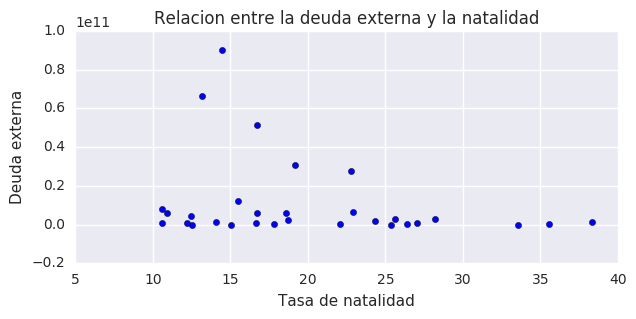

In [339]:
plt.figure(figsize=(7,3))
plt.scatter(x=datos.natalidad, y=datos.deuda)

plt.title('Relacion entre la deuda externa y la natalidad')
plt.xlabel('Tasa de natalidad')
plt.ylabel('Deuda externa');

En principio no parece que haya relación. Podemos calcular el coeficiente de correlación de pearson

In [375]:
stats.pearsonr(datos.deuda, datos.natalidad)

(-0.25837657467388314, 0.16802000034671716)

El valor indica que prácticamente no hay correlación, y el p valor no permite rechazar la ausencia de correlacion. Sin embargo, el coeficiente de correlación lineal  de Pearson asume normalidad en los datos. Utilizo el test de Shapiro-Wilk para ver si las variables se distribuyen de manera normal. La hipótesis nula de este test es que sí que hay normalidad

In [373]:
normalidad_deuda = stats.shapiro(datos.deuda)
normalidad_deuda # se rechaza la normalidad

(0.5649515390396118, 2.7980471273281182e-08)

In [374]:
normaidad_natalidad = stats.shapiro(datos.natalidad)
normaidad_natalidad # se rechaza la normalidad

(0.9237159490585327, 0.03352253511548042)

Para ambas variables, el p valor es lo suficientemente bajo como para rechazar la hipótesis nula de noramlidad de los datos. El coeficiente de pearson no es adecuado. La no normalidad imposibilita también el uso de regresión lineal, que asume dicha normalidad.   

Sería más correcto utilizar el coeficiente de correlación de Spearman. Este test plantea como hipótesis nula la __ausencia de correlación__, y no asume que los datos se distribuyen de manera normal, así que es adecuado para este caso.

In [370]:
stats.spearmanr(natalidad, deuda) # no se rechaza la no-correlacion

SpearmanrResult(correlation=-0.2649610678531702, pvalue=0.15706185937176095)

Para el p valor obtenido, no se rechaza la hipótesis nula de no correlación. No es posible rechazar que la deuda __no esté correlacionada__ con la natalidad.

En síntesis: los datos de deuda no presentan relación con la tasa de natalidad, al menos en este dataset